In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import tensorflow as tf
import pandas as pd
from data_info import *
from preprocessing_helpers import *
from datetime import datetime
%matplotlib inline
pd.set_option("display.precision", 2)
tf.random.set_seed(42)

In [208]:
new_iq_norm = [
                'reanalysis_tdtr_k',
                'reanalysis_sat_precip_amt_mm',
                'reanalysis_relative_humidity_percent',
                'station_avg_temp_c',
                'reanalysis_min_air_temp_k',
                'reanalysis_dew_point_temp_k',
                'reanalysis_specific_humidity_g_per_kg',
]
new_iq_scale = [
                   'year',
]

extra_iq_cols = [
]
new_sj_norm = [
                'precipitation_amt_mm',
                'reanalysis_air_temp_k',
                'reanalysis_avg_temp_k',
                'reanalysis_max_air_temp_k',
                'reanalysis_min_air_temp_k',
                'reanalysis_precip_amt_kg_per_m2',
                'reanalysis_relative_humidity_percent',
                'reanalysis_sat_precip_amt_mm',
                'station_avg_temp_c',
                'station_max_temp_c',
                'station_min_temp_c',
                'station_precip_mm'
]
new_sj_scale = [
                   'weekofyear',
]

extra_sj_cols = [
]
new_iq_cols = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + new_iq_norm + new_iq_scale + extra_iq_cols + [DATETIME_COLUMN]
new_iq_cols_no_label = CATEGORICAL_COLUMNS + new_iq_norm + new_iq_scale + extra_iq_cols + [DATETIME_COLUMN]
new_sj_cols = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + new_sj_norm + new_sj_scale + extra_sj_cols + [DATETIME_COLUMN]
new_sj_cols_no_label = CATEGORICAL_COLUMNS + new_sj_norm + new_sj_scale + extra_sj_cols + [DATETIME_COLUMN]




In [256]:
sj_datasets, sj_norm_scale = generate_lstm_data(
    train_file, 
    single_step=True, 
    history_size=24, 
    cols=new_sj_cols, 
    norm_cols=new_sj_norm, 
    scale_cols=new_sj_scale,
    extra_columns=extra_sj_cols,
    prepend_with_file=train_file,
    train_frac=1.0
)
sj_train_x, sj_train_y = sj_datasets[0][0]
iq_datasets, iq_norm_scale = generate_lstm_data(
    train_file, 
    single_step=True, 
    history_size=32, 
    cols=new_iq_cols, 
    norm_cols=new_iq_norm, 
    scale_cols=new_iq_scale,
    extra_columns=extra_iq_cols,
    prepend_with_file=train_file,
    train_frac=1.0
)
iq_train_x, iq_train_y = iq_datasets[1][0]
len(sj_train_x)

936

In [257]:
(sj_train_x, sj_train_y) = sj_datasets[0][0]
(iq_train_x, iq_train_y) = iq_datasets[1][0]
sj_train_x = sj_train_x.reshape(sj_train_x.shape[0], sj_train_x.shape[1] * sj_train_x.shape[2])
iq_train_x = iq_train_x.reshape(iq_train_x.shape[0], iq_train_x.shape[1] * iq_train_x.shape[2])

In [258]:
BATCH_SIZE = 16
BUFFER_SIZE = 500
train_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_train_x, sj_train_y))
train_sj_data_single = train_sj_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(10)

# val_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_val_x, sj_val_y))
# val_sj_data_single = val_sj_data_single.batch(BATCH_SIZE).repeat()

In [259]:
# Build network with 
def build_model(optimizer = None, nodes=256, input_shape=sj_train_x.shape[-1]):
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(nodes, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(nodes/2, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
  ])

  if not optimizer:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.9999, amsgrad=False)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

print(sj_train_x.shape[-2:])

(936, 312)


In [260]:
log_dir="logs/fit/lstm" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# create model
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.01, nesterov=False, name='SGD')


# Train the Model.
EVALUATION_INTERVAL = 200
EPOCHS = 8

# opt = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.9999, amsgrad=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="mae", factor=0.8, patience=3, min_lr=1e-6, verbose=1,
                                                     mode="max")

train_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_train_x, sj_train_y))
train_sj_data_single = train_sj_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)
sj_model = build_model(optimizer=opt, nodes=80)
history = sj_model.fit(
    train_sj_data_single,
    epochs=EPOCHS, 
    steps_per_epoch=EVALUATION_INTERVAL,
    verbose=1,
    callbacks=[tensorboard_callback, reduce_lr])

Train for 200 steps
Epoch 1/8
200/200 [==============================] - 1s 5ms/step - loss: 23.6283 - mae: 23.5620 - mse: 2523.5913
Epoch 2/8
200/200 [==============================] - 1s 3ms/step - loss: 20.7525 - mae: 20.8199 - mse: 2119.7437
Epoch 3/8
200/200 [==============================] - 1s 3ms/step - loss: 20.6126 - mae: 20.5155 - mse: 1942.2743
Epoch 4/8
191/200 [===========================>..] - ETA: 0s - loss: 19.1236 - mae: 19.1138 - mse: 1545.6267
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.
200/200 [==============================] - 1s 3ms/step - loss: 19.0665 - mae: 19.0567 - mse: 1535.5420
Epoch 5/8
200/200 [==============================] - 1s 3ms/step - loss: 17.0777 - mae: 17.0841 - mse: 1203.8824
Epoch 6/8
200/200 [==============================] - 1s 3ms/step - loss: 16.6091 - mae: 16.6291 - mse: 1134.1952
Epoch 7/8
197/200 [============================>.] - ETA: 0s - loss: 15.9321 - mae: 15.9155 - mse: 1029.9720
Epoch 00007: Re

In [261]:
train_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_train_x, iq_train_y))
train_iq_data_single = train_iq_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

EPOCHS = 22
# opt = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.9999, amsgrad=False)
opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)
iq_model = build_model(optimizer=opt, nodes=70, input_shape=iq_train_x.shape[-1])
train_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_train_x, iq_train_y))
train_iq_data_single = train_iq_data_single.cache().batch(BATCH_SIZE).repeat()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="mae", factor=0.8, patience=5, min_lr=1e-6, verbose=1,
                                                     mode="max")
history = iq_model.fit(
    train_iq_data_single,
    epochs=EPOCHS, 
    steps_per_epoch=EVALUATION_INTERVAL,
    verbose=1,
    callbacks=[tensorboard_callback, reduce_lr])

Train for 200 steps
Epoch 1/22
200/200 [==============================] - 1s 6ms/step - loss: 7.1778 - mae: 7.2382 - mse: 142.4678
Epoch 2/22
200/200 [==============================] - 1s 3ms/step - loss: 6.3266 - mae: 6.3800 - mse: 128.3225
Epoch 3/22
200/200 [==============================] - 1s 3ms/step - loss: 6.0856 - mae: 6.1311 - mse: 123.5562
Epoch 4/22
200/200 [==============================] - 1s 3ms/step - loss: 5.9684 - mae: 6.0243 - mse: 121.5550
Epoch 5/22
200/200 [==============================] - 1s 3ms/step - loss: 5.8419 - mae: 5.8898 - mse: 118.6618
Epoch 6/22
198/200 [============================>.] - ETA: 0s - loss: 5.6804 - mae: 5.7353 - mse: 115.7532
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
200/200 [==============================] - 1s 3ms/step - loss: 5.6425 - mae: 5.6960 - mse: 114.6366
Epoch 7/22
200/200 [==============================] - 1s 3ms/step - loss: 5.5578 - mae: 5.6199 - mse: 113.5947
Epoch 8/22
200/200 [========

In [265]:
file = train_file
file = test_file

org_sj_test_data, test_scale = generate_lstm_data(
    file, history_size=24, 
    cols=new_sj_cols_no_label, 
    norm_cols=new_sj_norm, 
    scale_cols=new_sj_scale, 
    single_step=True, 
    train_frac=1.0, train_scale=sj_norm_scale, 
    prepend_with_file=train_file,
    extra_columns=extra_sj_cols
)
org_iq_test_data, test_scale = generate_lstm_data(
    file, history_size=32, 
    cols=new_iq_cols_no_label, 
    norm_cols=new_iq_norm, 
    scale_cols=new_iq_scale, 
    single_step=True, 
    train_frac=1.0, train_scale=iq_norm_scale, 
    prepend_with_file=train_file,
    extra_columns=extra_iq_cols
)
(sj_test_x, sj_test_y), = org_sj_test_data[0]
(iq_test_x, iq_test_y), = org_iq_test_data[1]
sj_test_x = sj_test_x.reshape(sj_test_x.shape[0], sj_test_x.shape[1] * sj_test_x.shape[2])
iq_test_x = iq_test_x.reshape(iq_test_x.shape[0], iq_test_x.shape[1] * iq_test_x.shape[2])
sj_test_set = tf.data.Dataset.from_tensor_slices((sj_test_x, sj_test_y)).batch(len(sj_test_y))

sj_pred = []
for x, y in sj_test_set.take(1):
    predictions = sj_model.predict(x)
    sj_pred = predictions.flatten()
    print(len(predictions.flatten()))

260


In [266]:
iq_test_set = tf.data.Dataset.from_tensor_slices((iq_test_x, iq_test_y)).batch(len(iq_test_y))
iq_pred = []
for x, y in iq_test_set.take(1):
    predictions = iq_model.predict(x)
    iq_pred = predictions.flatten()
    print(len(predictions.flatten()))

156


In [267]:
from preprocessing_helpers import export_test_to_csv
preds = np.concatenate((sj_pred, iq_pred), axis=None)
export_test_to_csv(predictions=preds,path=file, prefix='test' if file == test_file else 'train')

416
asas


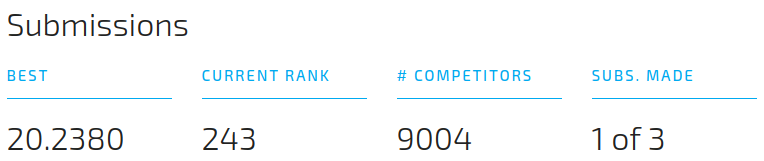

In [268]:
#Current Ranking (baseline)
Image("img/current-13-05.png")

In [15]:
# Tensorboard
# https://tensorboard.dev/experiment/rsdMubj0S165iOdLmbd13A/#scalars

In [269]:
# sj_model.save('models/sj_model_20,2380MAP.h5') 
# iq_model.save('models/iq_model_20,2380MAP.h5') 